Connected to spd-env (Python 3.12.2)

In [1]:
import json
from collections.abc import Callable, Iterable, Sequence
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from jaxtyping import Float, Int
from torch import Tensor

from spd.models.base import Model, SPDModel
from spd.models.bool_circuit_models import MLPComponents

In [2]:
def initialize_embeds(
    W_E: nn.Linear,
    W_U: nn.Linear,
    n_inputs: int,
    d_embed: int,
    superposition: bool,
    torch_gen: torch.Generator | None = None,
):
    if torch_gen is None:
        torch_gen = torch.Generator()
    W_E.weight.data = torch.zeros(d_embed, n_inputs)
    W_E.weight.data[0, 0] = 1.0
    num_functions = n_inputs - 1
    d_control = d_embed - 2

    if not superposition:
        W_E.weight.data[1:-1, 1:] = torch.eye(num_functions)
    else:
        random_matrix = torch.randn(d_control, num_functions, generator=torch_gen)
        random_normalised = random_matrix / torch.norm(random_matrix, dim=1, keepdim=True)
        W_E.weight.data[1:-1, 1:] = random_normalised

    W_U.weight.data = torch.zeros(1, d_embed)  # Assuming n_outputs is always 1
    W_U.weight.data[:, -1] = 1.0


class PiecewiseLinear(nn.Module):
    """
    this class is initialised with a function from real numbers to real numbers, a range
    (start,end]], and a num_neurons. It returns a neural network with one hidden layer of
    num_neurons relus with biases given by np.linspace(start, end, num_neurons) that computes a
    piecewise linear approximation to the function"""

    def __init__(
        self,
        f: Callable[[Float[Tensor, " n_inputs"]], Float[Tensor, " n_inputs"]],
        start: float,
        end: float,
        num_neurons: int,
    ):
        super().__init__()
        self.f = f
        self.start = start
        self.end = end
        self.num_neurons = num_neurons

        self.interval = (end - start) / (num_neurons - 1)
        self.input_layer = nn.Linear(1, num_neurons, bias=True)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(self.num_neurons, 1, bias=True)

        self.initialise_params()

    def initialise_params(self):
        biases = -np.linspace(self.start, self.end, self.num_neurons) + self.interval
        assert (
            len(biases) == self.num_neurons
        ), f"len(biases) = {len(biases)}, num_neurons = {self.num_neurons}, biases = {biases}"

        self.input_layer.bias.data = torch.tensor(biases, dtype=torch.float32)
        # -torch.tensor(
        #     np.linspace(start-self.interval, end, num_neurons), dtype=torch.float32
        # )[:-1] + self.interval
        # print("neuron bias", self.neurons.bias.data)
        self.input_layer.weight.data = torch.ones(self.num_neurons, 1, dtype=torch.float32)

        self.output_layer.bias.data = torch.tensor(0, dtype=torch.float32)

        xs = torch.linspace(self.start, self.end, self.num_neurons)
        self.function_values = torch.tensor([self.f(x) for x in xs], dtype=torch.float32)
        self.function_values = torch.cat(
            [torch.tensor([0], dtype=torch.float32), self.function_values]
        )
        slopes = (self.function_values[1:] - self.function_values[:-1]) / self.interval
        slope_diffs = torch.zeros(self.num_neurons, dtype=torch.float32)
        slope_diffs[0] = slopes[0]
        slope_diffs[1:] = slopes[1:] - slopes[:-1]
        self.output_layer.weight.data = slope_diffs.view(-1, 1).T

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

    def plot(self, ax: plt.Axes, start: float, end: float, num_points: int):
        x = np.linspace(start, end, num_points)
        y = np.array([self.f(x) for x in x])
        ax.plot(x, y, label="f(x)")
        # print("input shape", torch.tensor(x, dtype=torch.float32).unsqueeze(1).shape)
        ax.plot(
            x,
            self.forward(torch.tensor(x, dtype=torch.float32).unsqueeze(1)).detach().numpy(),
            label="NN(x)",
        )
        ax.legend()
        ax.set_title("Piecewise Linear Approximation")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        # add vertical lines to show start and end
        ax.axvline(x=self.start, color="r", linestyle="--")
        ax.axvline(x=self.end, color="r", linestyle="--")


class ControlledPiecewiseLinear(nn.Module):
    """
    Takes in a list of num_functions functions, and a range (start, end), and a num_neurons. It
    creates a neural network which takes in x and a list of num_functions control bits. It outputs
    num_functions different real numbers. If the i-th control bit is 1, the i-th output is the
    output of the piecewise linear approximation to the i-th function. Otherwise, the i-th output is
    0. The piecewise linear approximation is done with num_neurons neurons.
    """

    def __init__(
        self,
        functions: Sequence[Callable[[Float[Tensor, " n_inputs"]], Float[Tensor, " n_inputs"]]],
        start: float,
        end: float,
        num_neurons: int,
        d_control: int,
        control_W_E: torch.Tensor | None = None,
        suppression_size: int = 100,
        rng: np.random.Generator | None = None,
        torch_gen: torch.Generator | None = None,
        simple_bias: bool = False,
    ):
        super().__init__()
        self.functions = functions
        self.num_functions = len(functions)
        self.start = start
        self.end = end
        self.num_neurons = num_neurons
        self.suppression_size = suppression_size
        self.d_control = d_control
        self.control_W_E = control_W_E
        self.input_layer = nn.Linear(
            self.d_control + 1, self.num_functions * self.num_neurons, bias=True
        )
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(
            self.num_functions * self.num_neurons, self.num_functions, bias=True
        )
        self.initialise_params(rng, torch_gen, simple_bias)

    def initialise_params(
        self,
        rng: np.random.Generator | None = None,
        torch_gen: torch.Generator | None = None,
        simple_bias: bool = True,
    ):
        if rng is None:
            rng = np.random.default_rng()
        if torch_gen is None:
            torch_gen = torch.Generator()

        self.control_W_E = (
            torch.eye(self.num_functions) if self.control_W_E is None else self.control_W_E
        )
        assert (
            self.control_W_E.shape[0] <= self.num_functions
        ), "control_W_E should have at most num_functions rows"
        assert self.d_control == self.control_W_E.shape[1], "control_W_E should have d_control cols"
        self.piecewise_linears = [
            PiecewiseLinear(f, self.start, self.end, self.num_neurons) for f in self.functions
        ]
        # initialise all weights to 0
        self.input_layer.weight.data = torch.zeros(
            self.num_functions * self.num_neurons, self.d_control + 1
        )
        self.output_layer.weight.data = torch.zeros(
            self.num_functions, self.num_functions * self.num_neurons
        )
        for i in range(self.num_functions):
            piecewise_linear = self.piecewise_linears[i]

            self.input_layer.weight.data[i * self.num_neurons : (i + 1) * self.num_neurons, 0] = (
                piecewise_linear.input_layer.weight.data.squeeze()
            )
            if simple_bias:
                self.input_layer.bias.data[
                    i * self.num_neurons : (i + 1) * self.num_neurons
                ] = -self.suppression_size
                self.input_layer.weight.data[
                    i * self.num_neurons : (i + 1) * self.num_neurons, 1:
                ] += self.control_W_E[i] * (
                    self.suppression_size + piecewise_linear.input_layer.bias.data.unsqueeze(1)
                )
            else:
                self.input_layer.bias.data[i * self.num_neurons : (i + 1) * self.num_neurons] = (
                    piecewise_linear.input_layer.bias.data - self.suppression_size
                )
                self.input_layer.weight.data[
                    i * self.num_neurons : (i + 1) * self.num_neurons, 1:
                ] = self.control_W_E[i] * self.suppression_size

            self.output_layer.bias.data[i] = piecewise_linear.output_layer.bias.data
            self.output_layer.weight.data[i, i * self.num_neurons : (i + 1) * self.num_neurons] = (
                piecewise_linear.output_layer.weight.data.squeeze()
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        control_bits = x[:, 1:]
        input_value = x[:, 0].unsqueeze(1)
        assert control_bits.shape[1] == self.num_functions
        assert torch.all((control_bits == 0) | (control_bits == 1))
        control_vectors = control_bits @ self.control_W_E
        if control_vectors.dim() == 1:
            control_vectors = control_vectors.unsqueeze(0).repeat(len(x), 1)
        control_vectors = control_vectors.to(torch.float32)
        x = torch.cat([input_value, control_vectors], dim=1)
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

    def plot(
        self, start: float, end: float, num_points: int, control_bits: torch.Tensor | None = None
    ):
        # make a figure with self.num_functions subplots
        fig, axs = plt.subplots(self.num_functions, 1, figsize=(10, 5 * self.num_functions))
        assert isinstance(axs, Iterable)
        x = np.linspace(start, end, num_points)
        if control_bits is None:
            control_bits = torch.zeros(len(x), self.num_functions)
        if control_bits.dim() == 1:
            control_bits = control_bits.unsqueeze(0).repeat(len(x), 1)
        assert control_bits.shape[1] == self.num_functions
        assert control_bits.shape[0] == len(x)
        input = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
        input_with_control = torch.cat([input, control_bits], dim=1)
        outputs = self.forward(input_with_control).detach().numpy()
        for i in range(self.num_functions):
            target = np.array([self.functions[i](x) for x in x])
            axs[i].plot(x, target, label="f(x)")
            # print("input shape", torch.tensor(x, dtype=torch.float32).unsqueeze(1).shape)
            axs[i].plot(x, outputs[:, i], label="NN(x)")
            axs[i].legend()
            axs[i].set_title(f"Piecewise Linear Approximation of function {i}")
            axs[i].set_xlabel("x")
            axs[i].set_ylabel("y")
            # add vertical lines to show start and end
            axs[i].axvline(x=self.start, color="r", linestyle="--")
            axs[i].axvline(x=self.end, color="r", linestyle="--")
        plt.show()


class MLP(nn.Module):
    def __init__(self, d_model: int, d_mlp: int, initialise_zero=True):
        super().__init__()
        self.d_model = d_model
        self.d_mlp = d_mlp
        self.input_layer = nn.Linear(d_model, d_mlp)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(d_mlp, d_model)
        if initialise_zero:
            self.initialise_zero()

    def initialise_zero(self):
        self.input_layer.weight.data = torch.zeros(self.d_mlp, self.d_model)
        self.input_layer.bias.data = torch.zeros(self.d_mlp)
        self.output_layer.weight.data = torch.zeros(self.d_model, self.d_mlp)
        self.output_layer.bias.data = torch.zeros(self.d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x


class ControlledResNet(nn.Module):
    """
    Same inputs as ControlledPiecewiseLinear, but also takes in an input n_layers. Now it creates
    a network which has the same input and output as ControlledPiecewiseLinear, but the inputs and
    outputs lie in orthogonal parts of a single residual stream, and the neurons are randomly
    distributed across the layers.
    """

    def __init__(
        self,
        functions: Sequence[Callable[[Float[Tensor, " n_inputs"]], Float[Tensor, " n_inputs"]]],
        start: float,
        end: float,
        neurons_per_function: int,
        n_layers: int,
        d_control: int,
        suppression_size: int = 100,
        rng: np.random.Generator | None = None,
        torch_gen: torch.Generator | None = None,
        simple_bias: bool = True,
    ):
        super().__init__()
        self.functions = functions
        self.d_control = d_control
        self.num_functions = len(functions)
        self.start = start
        self.end = end
        self.num_neurons = neurons_per_function
        self.n_layers = n_layers
        self.total_neurons = neurons_per_function * self.num_functions
        assert self.total_neurons % n_layers == 0, "num_neurons must be divisible by num layers"
        self.suppression_size = suppression_size
        self.simple_bias = simple_bias

        self.d_mlp = self.total_neurons // n_layers
        # d_model: one for x, one for each control bit, and one for y (the output of the controlled
        # piecewise linear)
        self.d_model = self.d_control + 2
        self.mlps = nn.ModuleList([MLP(self.d_model, self.d_mlp) for _ in range(n_layers)])
        self.initialise_params(rng, torch_gen)

    def initialise_params(
        self, rng: np.random.Generator | None = None, torch_gen: torch.Generator | None = None
    ):
        if rng is None:
            rng = np.random.default_rng()
        if torch_gen is None:
            torch_gen = torch.Generator()

        if self.d_control == self.num_functions:
            print("control_W_E is identity")
            self.control_W_E = torch.eye(self.d_control)
        else:
            random_matrix = torch.randn(self.d_control, self.num_functions, generator=torch_gen)
            # normalise rows
            self.control_W_E = random_matrix / random_matrix.norm(dim=1).unsqueeze(1)

        self.controlled_piecewise_linear = ControlledPiecewiseLinear(
            self.functions,
            self.start,
            self.end,
            self.num_neurons,
            self.d_control,
            self.control_W_E,
            self.suppression_size,
            rng,
            torch_gen,
            self.simple_bias,
        )

        # create a random permutation of the neurons
        self.neuron_permutation = torch.randperm(self.total_neurons, generator=torch_gen)
        # split the neurons into n_layers parts
        self.neuron_permutations = torch.split(self.neuron_permutation, self.d_mlp)
        # create n_layers residual layers

        output_weights_summed = self.controlled_piecewise_linear.output_layer.weight.data.sum(dim=0)

        # set the weights of the residual layers to be the weights of the corresponding neurons in
        # the controlled piecewise linear
        for i in range(self.n_layers):
            self.mlps[i].input_layer.weight.data[:, :-1] = (
                self.controlled_piecewise_linear.input_layer.weight.data[
                    self.neuron_permutations[i]
                ]
            )
            self.mlps[
                i
            ].input_layer.bias.data = self.controlled_piecewise_linear.input_layer.bias.data[
                self.neuron_permutations[i]
            ]
            self.mlps[i].output_layer.weight.data[-1] = output_weights_summed[
                self.neuron_permutations[i]
            ]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # concatenate x and control bits
        control_bits = x[:, 1:]
        input_value = x[:, 0].unsqueeze(1)

        assert (
            control_bits.shape[1] == self.num_functions
        ), "control bits should have num_functions columns"
        assert torch.all((control_bits == 0) | (control_bits == 1)), "control bits should be 0 or 1"
        # map control bits to control vectors
        control_vectors = control_bits @ self.control_W_E
        x = torch.cat([input_value, control_vectors], dim=1)

        # add a zero for the output of the controlled piecewise linear
        x = torch.cat([x, torch.zeros_like(x[:, :1])], dim=1)

        assert x.shape[1] == self.d_model
        for i in range(self.n_layers):
            x = x + self.mlps[i](x)
        return x

    def partial_forward(
        self, x: torch.Tensor, layer: int | None = None, control_bits: torch.Tensor | None = None
    ) -> torch.Tensor:
        # return the output of the network up to layer
        if control_bits is None:
            control_bits = torch.zeros(x.shape[0], self.num_functions)
        assert control_bits.shape[1] == self.num_functions
        assert control_bits.shape[0] == x.shape[0]
        if layer is None:
            layer = self.n_layers
        x = torch.cat([x, control_bits], dim=1)
        x = torch.cat([x, torch.zeros_like(x[:, :1])], dim=1)
        for i in range(layer):
            x = x + self.mlps[i](x)
        return x

    def plot(
        self,
        start: float,
        end: float,
        num_points: int,
        layers: int | list[int] | None = None,
        control_bits: torch.Tensor | None = None,
    ):
        # make a figure
        fig, ax = plt.subplots(figsize=(10, 10))
        x = np.linspace(start, end, num_points)
        if control_bits is None:
            control_bits = torch.zeros(self.num_functions)
        assert control_bits.shape == (
            self.num_functions,
        ), "control_bits should be a 1D tensor for the plot function"
        input_control_bits = control_bits.unsqueeze(0).repeat(len(x), 1)

        target = np.zeros((self.num_functions, len(x)))
        for i in range(self.num_functions):
            target[i] = np.array([self.functions[i](x) for x in x])
        target = torch.einsum("fb,f -> b", torch.tensor(target, dtype=torch.float32), control_bits)
        ax.plot(x, target, label="f(x)", linewidth=8)

        if layers is None:
            layers = list(range(self.n_layers + 1))
        elif isinstance(layers, int):
            layers = [layers]
        for layer in layers:
            outputs = (
                self.partial_forward(
                    torch.tensor(x, dtype=torch.float32).unsqueeze(1),
                    layer=layer,
                    control_bits=input_control_bits,
                )
                .detach()
                .numpy()
            )
            ax.plot(x, outputs[:, -1], label=f"layer {layer} NN(x)")

        ax.legend()

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        # add vertical lines to show start and end
        ax.axvline(x=self.start, color="r", linestyle="--")
        ax.axvline(x=self.end, color="r", linestyle="--")
        # set ylim between min and max value of target
        ax.set_ylim([target.min().item() - 2, target.max().item() + 2])  # type: ignore
        plt.show()


class PiecewiseFunctionTransformer(Model):
    def __init__(
        self,
        n_inputs: int,
        d_mlp: int,
        n_layers: int,
        d_embed: int | None = None,
    ):
        super().__init__()
        self.n_inputs = n_inputs
        self.d_mlp = d_mlp
        self.n_layers = n_layers
        self.d_embed = self.n_inputs + 1 if d_embed is None else d_embed
        self.d_control = self.d_embed - 2

        self.num_functions = n_inputs - 1
        self.n_outputs = 1  # this is hardcoded. This class isn't defined for multiple outputs

        self.superposition = self.num_functions > self.d_control
        if not self.superposition:
            assert self.num_functions == self.d_control

        self.W_E = nn.Linear(n_inputs, self.d_embed, bias=False)
        self.W_U = nn.Linear(self.d_embed, self.n_outputs, bias=False)

        initialize_embeds(self.W_E, self.W_U, n_inputs, self.d_embed, self.superposition)

        self.mlps = nn.ModuleList([MLP(d_model=self.d_embed, d_mlp=d_mlp) for _ in range(n_layers)])

    def forward(self, x: Tensor) -> Tensor:
        residual = self.W_E(x)
        for layer in self.mlps:
            residual = residual + layer(residual)
        return self.W_U(residual)

    def all_decomposable_params(self) -> list[Float[Tensor, "..."]]:
        """List of all parameters which will be decomposed with SPD."""
        params = []
        for mlp in self.mlps:
            params.append(mlp.input_layer.weight.T)
            params.append(mlp.output_layer.weight.T)
        return params

    @classmethod
    def from_handcoded(
        cls,
        functions: list[Callable[[Float[Tensor, " n_inputs"]], Float[Tensor, " n_inputs"]]],
        neurons_per_function: int = 200,
        n_layers: int = 4,
        range_min: float = 0,
        range_max: float = 5,
        seed: int | None = None,
        simple_bias: bool = True,
    ) -> "PiecewiseFunctionTransformer":
        if seed is not None:
            # Create local random number generators
            rng = np.random.default_rng(seed)
            torch_gen = torch.Generator()
            torch_gen.manual_seed(seed)
        else:
            rng = None
            torch_gen = None

        n_inputs = len(functions) + 1
        neurons_per_function = neurons_per_function
        d_mlp = neurons_per_function * len(functions) // n_layers
        d_embed = n_inputs + 1
        model = cls(n_inputs=n_inputs, d_mlp=d_mlp, n_layers=n_layers)
        # Note that our MLP differs from the bool_circuit_models.MLP in having b_out
        # Also different names
        assert len(functions) == d_embed - 2
        assert len(functions) == n_inputs - 1
        handcoded_model = ControlledResNet(
            functions,
            start=range_min,
            end=range_max,
            neurons_per_function=neurons_per_function,
            n_layers=n_layers,
            d_control=d_embed - 2,  # no superpos
            suppression_size=int(range_max + 1),
            rng=rng,
            torch_gen=torch_gen,
            simple_bias=simple_bias,
        )
        # Copy the weights from the hand-coded model to the model

        # the control_W_E of the ControlledResNet class is just a part of the W_E of this class. In
        # particular it is the part that is sliced in by the random matrix (or identity)
        initialize_embeds(model.W_E, model.W_U, n_inputs, d_embed, model.superposition)

        for i, mlp in enumerate(handcoded_model.mlps):
            model.mlps[i].input_layer.weight.data = mlp.input_layer.weight
            model.mlps[i].output_layer.weight.data = mlp.output_layer.weight

            model.mlps[i].input_layer.bias.data = mlp.input_layer.bias
            assert torch.all(mlp.output_layer.bias.data == 0), "Output layer bias should be zero"
            model.mlps[i].output_layer.bias.data = mlp.output_layer.bias

        return model

    def plot(
        self,
        start: float,
        end: float,
        num_points: int,
        functions: list[Callable[[Float[Tensor, " n_inputs"]], Float[Tensor, " n_inputs"]]]
        | None = None,
    ):
        fig, axs = plt.subplots(self.num_functions, 1, figsize=(10, 5 * self.num_functions))
        assert isinstance(axs, Iterable)
        x = torch.linspace(start, end, num_points)

        for i in range(self.num_functions):
            input_with_control = torch.zeros(num_points, self.n_inputs)
            input_with_control[:, 0] = x
            input_with_control[:, i + 1] = 1.0
            outputs = self.forward(input_with_control).detach().numpy()
            if functions is not None:
                target = [functions[i](xi) for xi in x]
                axs[i].plot(x, target, label="f(x)")
            axs[i].plot(x, outputs[:, 0], label="NN(x)")
            axs[i].legend()
            axs[i].set_title(f"Piecewise Linear Approximation of function {i}")
            axs[i].set_xlabel("x")
            axs[i].set_ylabel("y")
            axs[i].axvline(x=start, color="r", linestyle="--")
            axs[i].axvline(x=end, color="r", linestyle="--")
        plt.show()

    def plot_multiple(
        self,
        start: float,
        end: float,
        num_points: int,
        functions: list[Callable[[Float[Tensor, " n_inputs"]], Float[Tensor, " n_inputs"]]],
        prob: float = 0.5,
    ):
        """Plot the addition of multiple functions."""
        fig, axs = plt.subplots(1, 1, figsize=(10, 5))
        x = torch.linspace(start, end, num_points)

        inputs_with_control = torch.zeros(num_points, self.n_inputs)
        inputs_with_control[:, 0] = x
        control_bits = torch.bernoulli(torch.full((self.n_inputs - 1,), prob))
        # Use the same control bits for all points
        control_bits_expanded = control_bits.unsqueeze(0).repeat(num_points, 1)
        inputs_with_control[:, 1:] = control_bits_expanded

        f_inputs = inputs_with_control[:, 0].unsqueeze(1).expand(-1, len(functions))
        # x = inputs_with_control[:, 0].unsqueeze(1).expand(-1, len(functions))
        function_outputs = torch.stack([f(f_inputs[:, i]) for i, f in enumerate(functions)], dim=-1)

        labels = torch.einsum("bo,bo->b", control_bits_expanded, function_outputs)

        axs.plot(x, labels, label="f(x)")
        outputs = self.forward(inputs_with_control)
        axs.plot(x, outputs[:, 0].detach().numpy(), label="NN(x)")
        axs.legend()
        axs.set_title("Piecewise Linear Approximation of function")
        axs.set_xlabel("x")
        axs.set_ylabel("y")
        axs.axvline(x=start, color="r", linestyle="--")
        axs.axvline(x=end, color="r", linestyle="--")
        plt.show()


class PiecewiseFunctionSPDTransformer(SPDModel):
    """An SPD model for piecewise functions.

    Args:
        n_inputs: The number of input features
        d_mlp: The number of neurons in each MLP layer
        n_layers: The number of MLP layers
        k: The number of components to keep
        input_biases: The biases for the first linear layer of each MLP
        d_embed: The dimension of the embedding space
    """

    def __init__(
        self,
        n_inputs: int,
        d_mlp: int,
        n_layers: int,
        k: int,
        input_biases: list[Float[Tensor, " d_mlp"]] | None = None,
        d_embed: int | None = None,
    ):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_layers = n_layers
        self.k = k
        self.d_embed = self.n_inputs + 1 if d_embed is None else d_embed
        self.d_control = self.d_embed - 2
        self.n_param_matrices = n_layers * 2

        self.num_functions = n_inputs - 1
        self.n_outputs = 1  # this is hardcoded. This class isn't defined for multiple outputs

        self.superposition = self.num_functions > self.d_control
        if not self.superposition:
            assert self.num_functions == self.d_control

        self.W_E = nn.Linear(n_inputs, self.d_embed, bias=False)
        self.W_U = nn.Linear(self.d_embed, self.n_outputs, bias=False)
        initialize_embeds(self.W_E, self.W_U, n_inputs, self.d_embed, self.superposition)

        self.input_component = nn.Parameter(torch.empty(self.d_embed, self.k))
        self.output_component = nn.Parameter(torch.empty(self.k, self.d_embed))

        self.mlps = nn.ModuleList(
            [
                MLPComponents(
                    d_embed=self.d_embed,
                    d_mlp=d_mlp,
                    k=k,
                    input_bias=input_biases[i] if input_biases is not None else None,
                    input_component=self.input_component,  # type: ignore
                    output_component=self.output_component,  # type: ignore
                )
                for i in range(n_layers)
            ]
        )

    def all_As(self) -> list[Float[Tensor, "dim k"]]:
        all_A_pairs = [
            (self.mlps[i].linear1.A, self.mlps[i].linear2.A) for i in range(self.n_layers)
        ]
        As = [A / A.norm(p=2, dim=-2, keepdim=True) for A_pair in all_A_pairs for A in A_pair]
        assert len(As) == self.n_param_matrices
        return As

    def all_Bs(self) -> list[Float[Tensor, "k dim"]]:
        # Get all B matrices
        all_B_pairs = [
            (self.mlps[i].linear1.B, self.mlps[i].linear2.B) for i in range(self.n_layers)
        ]
        As = [B for B_pair in all_B_pairs for B in B_pair]
        assert len(As) == self.n_param_matrices
        return As

    def forward(
        self, x: Float[Tensor, "... inputs"]
    ) -> tuple[
        Float[Tensor, "... outputs"],
        list[Float[Tensor, "... d_embed"] | Float[Tensor, "... d_mlp"]],
        list[Float[Tensor, "... k"]],
    ]:
        """
        Returns:
            x: The output of the model
            layer_acts: A list of activations for each layer in each MLP.
            inner_acts: A list of component activations for each layer in each MLP.
        """
        layer_acts = []
        inner_acts = []
        residual = self.W_E(x)
        for layer in self.mlps:
            layer_out, layer_acts_i, inner_acts_i = layer(residual)
            residual = residual + layer_out
            layer_acts.extend(layer_acts_i)
            inner_acts.extend(inner_acts_i)
        return self.W_U(residual), layer_acts, inner_acts

    def forward_topk(
        self, x: Float[Tensor, "... inputs"], topk_indices: Int[Tensor, "... topk"]
    ) -> tuple[
        Float[Tensor, "... outputs"],
        list[Float[Tensor, "... d_embed"] | Float[Tensor, "... d_mlp"]],
        list[Float[Tensor, "... k"]],
    ]:
        """
        Performs a forward pass using only the top-k components for each component activation.

        Args:
            x: Input tensor
            topk_indices: Indices of the top-k components to keep

        Returns:
            output: The output of the transformer
            layer_acts: A list of activations for each layer in each MLP
            inner_acts: A list of component activations for each layer in each MLP
        """
        layer_acts = []
        inner_acts = []
        residual = self.W_E(x)

        for i, layer in enumerate(self.mlps):
            layer_out, layer_acts_i, inner_acts_i = layer.forward_topk(residual, topk_indices)
            residual = residual + layer_out
            layer_acts.extend(layer_acts_i)
            inner_acts.extend(inner_acts_i)

        return self.W_U(residual), layer_acts, inner_acts

    @classmethod
    def from_pretrained(cls, path: str | Path) -> "PiecewiseFunctionSPDTransformer":
        path = Path(path)
        with open(path.parent / "config.json") as f:
            config = json.load(f)

        params = torch.load(path, weights_only=True, map_location="cpu")

        model = cls(
            n_inputs=config["n_inputs"],
            d_mlp=config["d_mlp"],
            n_layers=config["n_layers"],
            k=config["k"],
            d_embed=config["d_embed"],
        )
        model.load_state_dict(params)
        return model

In [3]:
from collections.abc import Callable

import numpy as np
import torch

from spd.models.piecewise_models import PiecewiseFunctionTransformer
from spd.scripts.piecewise.piecewise_decomposition import (
    generate_trig_functions,
)

In [4]:
# test
# make a list of 50 different cubic functions
def generate_cubics(num_cubics: int) -> list[Callable[[float], float]]:
    def create_cubic(a: float, b: float, c: float, d: float) -> Callable[[float], float]:
        return lambda x: a * x**3 + b * x**2 + c * x + d

    cubics = []
    for _ in range(num_cubics):
        a = np.random.uniform(-1, 1)
        b = np.random.uniform(-2, 2)
        c = np.random.uniform(-4, 4)
        d = np.random.uniform(-8, 8)
        cubics.append(create_cubic(a, b, c, d))
    return cubics


def generate_regular_simplex(num_vertices: int) -> torch.Tensor:
    # Create the standard basis in num_vertices dimensions
    basis = torch.eye(num_vertices)

    # Create the (1,1,...,1) vector
    ones = torch.ones(num_vertices)

    # Compute the Householder transformation
    v = ones / torch.norm(ones)
    last_basis_vector = torch.zeros(num_vertices)
    last_basis_vector[-1] = 1
    u = v - last_basis_vector
    u = u / torch.norm(u)

    # Apply the Householder transformation
    H = torch.eye(num_vertices) - 2 * u.outer(u)
    rotated_basis = basis @ H

    # Remove the last coordinate
    simplex = rotated_basis[:, :-1]

    # Center the simplex at the origin
    centroid = simplex.mean(dim=0)
    simplex = simplex - centroid

    return simplex / simplex.norm(dim=1).unsqueeze(1)

control_W_E is identity


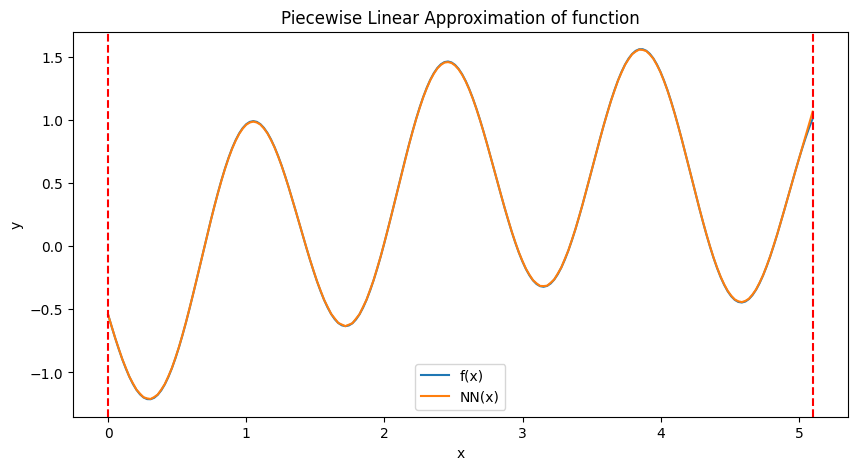

In [5]:
num_functions = 5
neurons_per_function = 100
feature_probability = 0.2
functions, _ = generate_trig_functions(num_functions)
test = PiecewiseFunctionTransformer.from_handcoded(
    functions=functions,
    neurons_per_function=neurons_per_function,
    n_layers=2,
    range_min=0,
    range_max=5,
)

# test.plot(-0.1, 5.1, 1000, control_bits=control_bits, functions=functions)
test.plot_multiple(start=-0, end=5.1, num_points=200, functions=functions, prob=feature_probability)

control_W_E is identity


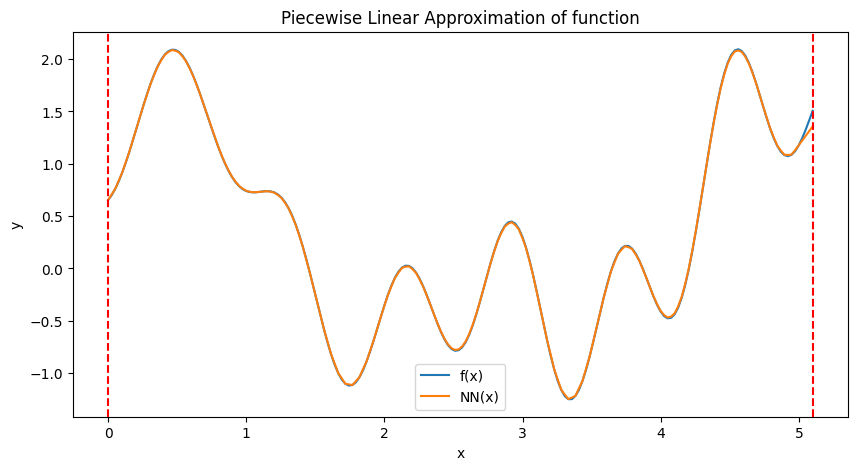

In [6]:
num_functions = 5
neurons_per_function = 100
feature_probability = 0.2
functions, _ = generate_trig_functions(num_functions)
test = PiecewiseFunctionTransformer.from_handcoded(
    functions=functions,
    neurons_per_function=neurons_per_function,
    n_layers=2,
    range_min=0,
    range_max=5,
    simple_bias=False
    
)

# test.plot(-0.1, 5.1, 1000, control_bits=control_bits, functions=functions)
test.plot_multiple(start=-0, end=5.1, num_points=200, functions=functions, prob=feature_probability)

control_W_E is identity


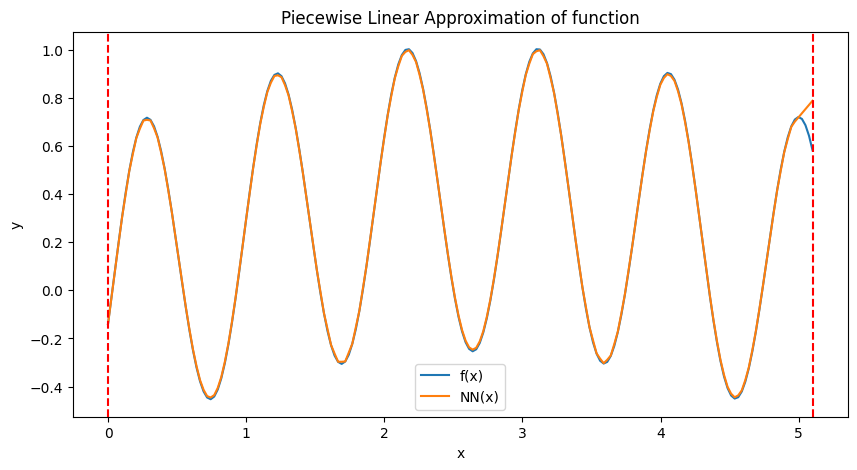

In [7]:
num_functions = 5
neurons_per_function = 100
feature_probability = 0.2
functions, _ = generate_trig_functions(num_functions)
test = PiecewiseFunctionTransformer.from_handcoded(
    functions=functions,
    neurons_per_function=neurons_per_function,
    n_layers=2,
    range_min=0,
    range_max=5,
    simple_bias=True
    
)

# test.plot(-0.1, 5.1, 1000, control_bits=control_bits, functions=functions)
test.plot_multiple(start=-0, end=5.1, num_points=200, functions=functions, prob=feature_probability)

control_W_E is identity


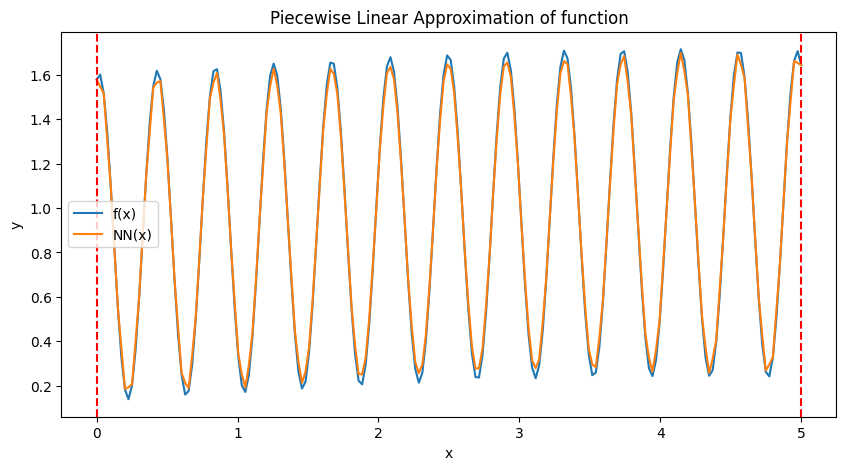

In [8]:
num_functions = 5
neurons_per_function = 100
feature_probability = 0.2
functions, _ = generate_trig_functions(num_functions)
test = PiecewiseFunctionTransformer.from_handcoded(
    functions=functions,
    neurons_per_function=neurons_per_function,
    n_layers=2,
    range_min=0,
    range_max=5,
    simple_bias=True
    
)

# test.plot(-0.1, 5.1, 1000, control_bits=control_bits, functions=functions)
test.plot_multiple(start=-0, end=5., num_points=200, functions=functions, prob=feature_probability)